In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


import warnings
warnings.simplefilter("ignore")

# The goal of this project is to 
With the credit card transaction data and individual profile,
- Report the card users who go above their monthly limit on a daily basis
- Look for transaction with fraud possibility for future investigating 

# Upload data

In [2]:
customer = pd.read_csv("cc_info.csv")
print(customer.shape)
customer.head(3)

(984, 5)


,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000


In [3]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
credit_card          984 non-null int64
city                 984 non-null object
state                984 non-null object
zipcode              984 non-null int64
credit_card_limit    984 non-null int64
dtypes: int64(3), object(2)
memory usage: 38.5+ KB


In [4]:
trans = pd.read_csv("transactions.csv", parse_dates=['date'])
print(trans.shape)
trans.head(3)

(294588, 5)


,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004


In [5]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null datetime64[ns]
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


- No missing value issue, great!

# Data processing

In [6]:
trans['month'] = trans['date'].apply(lambda x: x.month)
trans['day'] = trans['date'].apply(lambda x: x.day)
trans['weekday'] = trans['date'].apply(lambda x: x.dayofweek)
trans['hour'] = trans['date'].apply(lambda x: x.hour)
trans['minute'] = trans['date'].apply(lambda x: x.minute)
trans.sort_values(["credit_card", "date"], inplace = True)
trans.reset_index(inplace = True, drop = True)
trans["cum_sum"] = trans.groupby(["credit_card", "month"])["transaction_dollar_amount"].transform("cumsum")
trans.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,month,day,weekday,hour,minute,cum_sum
0,1003715054175576,2015-07-31 20:03:05,45.52,-80.186336,40.168399,7,31,4,20,3,45.52
1,1003715054175576,2015-07-31 20:25:28,96.10,-80.156132,40.222907,7,31,4,20,25,141.62
2,1003715054175576,2015-07-31 23:09:32,20.94,-80.262219,40.242532,7,31,4,23,9,162.56
3,1003715054175576,2015-08-01 10:48:03,51.27,-80.176899,40.313324,8,1,5,10,48,51.27
4,1003715054175576,2015-08-01 17:43:43,127.99,-80.226671,40.295995,8,1,5,17,43,179.26


In [7]:
merged = pd.merge(trans, customer, on = "credit_card")
merged.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat,month,day,weekday,hour,minute,cum_sum,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-07-31 20:03:05,45.52,-80.186336,40.168399,7,31,4,20,3,45.52,Houston,PA,15342,20000
1,1003715054175576,2015-07-31 20:25:28,96.10,-80.156132,40.222907,7,31,4,20,25,141.62,Houston,PA,15342,20000
2,1003715054175576,2015-07-31 23:09:32,20.94,-80.262219,40.242532,7,31,4,23,9,162.56,Houston,PA,15342,20000


# Q1: Identify users that never went above monthly credit limit

In [8]:
merged["above_limit"] = merged["cum_sum"] > merged["credit_card_limit"]
above_limit_times = pd.DataFrame(merged.groupby("credit_card")["above_limit"].sum()).reset_index()
above_limit_times.columns = ["credit_card","above_limit_times"]
zero_above_limit = above_limit_times[above_limit_times["above_limit_times"] == 0]
print(len(zero_above_limit))
zero_above_limit.head()

862


,credit_card,above_limit_times
0,1003715054175576,0.0
1,1013870087888817,0.0
2,1023820165155391,0.0
3,1073931538936472,0.0
4,1077622576192810,0.0


- So, there are 862 credit cards in total that never exceed their credit limit.

# Q2: Build a function returns users who went above monthly limit each day

In [9]:
def daily_report(month, day):
    over_limit = merged[merged["above_limit"] == True]
    query_result = over_limit[(over_limit["month"] == month) & (over_limit["day"] == day)]
    query_result = query_result.drop_duplicates("credit_card", keep = "last")
    return query_result

In [10]:
daily_report(month = 8, day = 16)

,credit_card,date,transaction_dollar_amount,Long,Lat,month,day,weekday,hour,minute,cum_sum,city,state,zipcode,credit_card_limit,above_limit
58136,2850146878241916,2015-08-16 23:05:17,7.42,-72.103198,43.109806,8,16,6,23,5,4012.81,Washington,NH,3280,4000,True
117129,4462290711836916,2015-08-16 02:35:10,130.76,-73.988243,40.727111,8,16,6,2,35,2846.88,New York,NY,10001,2000,True
230991,7850942767136368,2015-08-16 19:54:34,65.01,-72.140223,43.182095,8,16,6,19,54,4061.39,Washington,NH,3280,4000,True
252010,8522875529951473,2015-08-16 22:44:48,19.73,-72.058977,43.238693,8,16,6,22,44,5518.88,Washington,NH,3280,5000,True


- The daily_report(month, day) will reture the information about the ones that go above its limit on that day

# Search for unusual transactions that need to be investigated further

In [11]:
merged.head(2)

,credit_card,date,transaction_dollar_amount,Long,Lat,month,day,weekday,hour,minute,cum_sum,city,state,zipcode,credit_card_limit,above_limit
0,1003715054175576,2015-07-31 20:03:05,45.52,-80.186336,40.168399,7,31,4,20,3,45.52,Houston,PA,15342,20000,False
1,1003715054175576,2015-07-31 20:25:28,96.10,-80.156132,40.222907,7,31,4,20,25,141.62,Houston,PA,15342,20000,False


The dataset have three aspects of information:
- Transaction time
- Transaction amount
- Transaction location

There are two ways to define an unusual transaction:
- A small percentage in the dataset
- Different from the majority

Therefore, I need to compute the deviation from its normal situation of thees information:
- Transaction Time
- Transaction amount; transaction amount to credit limit; transaction amount to remaining credit
- Distance to its home address; since there is no home information, I will then compute its distance to the center point of all appeared locations;


### Feature Engineering

##### Time

In [12]:
merged["time_of_day"] = merged["hour"] + merged["minute"]/60.0
model_data = merged[["credit_card", "day", "weekday", "time_of_day"]]

##### Transaction amount

In [13]:
# assume there are 32 days in a month to prevent from dividing 0
merged["remaining_days"] = 32 - merged["day"]
merged["remaining_credit"] = merged["credit_card_limit"] - merged["cum_sum"]

model_data["trans_to_limit"] = merged["transaction_dollar_amount"]/merged["credit_card_limit"]
model_data["trans_to_remaincredit"] = merged["transaction_dollar_amount"]/merged["remaining_credit"]

##### Location

In [14]:
center_loc = merged.groupby("credit_card")["Long","Lat"].mean()
merged = pd.merge(merged, center_loc, on = "credit_card", how = "left")
model_data["distance"] = np.sqrt((merged["Long_x"] - merged["Long_y"])*(merged["Long_x"] - merged["Long_y"]) + 
                                  (merged["Lat_x"] - merged["Lat_y"]) * (merged["Lat_x"] - merged["Lat_y"]))

In [15]:
model_data.head(10)

,credit_card,day,weekday,time_of_day,trans_to_limit,trans_to_remaincredit,distance
0,1003715054175576,31,4,20.050000,0.002276,0.002281,2.661676
1,1003715054175576,31,4,20.416667,0.004805,0.004839,2.644244
2,1003715054175576,31,4,23.150000,0.001047,0.001056,2.751997
3,1003715054175576,1,5,10.800000,0.002564,0.002570,2.686681
4,1003715054175576,1,5,17.716667,0.006399,0.006457,2.730346
5,1003715054175576,1,5,17.733333,0.004848,0.004916,2.648800
6,1003715054175576,1,5,19.166667,0.004867,0.004960,2.647119
7,1003715054175576,2,6,19.650000,0.006572,0.006742,2.704566
8,1003715054175576,2,6,22.666667,0.004287,0.004417,2.737824
9,1003715054175576,3,0,0.450000,0.004033,0.004174,2.724879


### Isolation forest model

I will use isolation forest model to find the possible fraud transaction
- Note that I will not treat all the transaction data as one single sample, because the fraud criterion would be different. eg: for most people, transaction at 2:00am would be unusual, but it is normal for people who work in the night
- Therefore I will build a seperate model for different people.

Only look for possible fraud transaction for account with some threshold transaction times, because small data set is not rubost to indicate fraud
- set threshold = 50 in this case

In [16]:
trans_threshold = 50

In [17]:
all_card = model_data["credit_card"].unique()
all_labeled = pd.DataFrame()
ite_num = 0
for card in all_card:
    indi_trans = model_data[model_data["credit_card"] == card]
    ite_num = ite_num + 1
    
    if len(indi_trans) >= trans_threshold:
        if_model = IsolationForest(contamination=0.02, random_state=42)
        if_model.fit(indi_trans)
        label = if_model.predict(indi_trans)
        labeled = pd.DataFrame(label)
        all_labeled = pd.concat([all_labeled, labeled], axis = 0)
    
    if ite_num%300 == 0 :
        print ("iteration time is: " + str(ite_num))

iteration time is: 300
iteration time is: 600
iteration time is: 900


In [18]:
all_labeled.reset_index(inplace = True, drop = True)
all_labeled.shape

(292523, 1)

In [19]:
trans_acount = model_data.groupby("credit_card")["day"].transform("count").reset_index()
over_thres_data = model_data[trans_acount["day"] >= trans_threshold]
over_thres_data.reset_index(inplace = True, drop = True)
over_thres_data.shape

(292523, 7)

The number of rows match! Great!

In [20]:
over_thres_data = pd.concat([over_thres_data,all_labeled], axis = 1)
over_thres_data.rename(columns = {0:"label"}, inplace = True)
over_thres_data["fraud"] = np.abs((over_thres_data["label"] - 1)*-0.5)
over_thres_data.drop("label", inplace = True, axis = 1)

In [21]:
over_thres_data["trans_to_limit"] = over_thres_data["trans_to_limit"]*100
over_thres_data["trans_to_remaincredit"] = over_thres_data["trans_to_remaincredit"]*100
over_thres_data = over_thres_data*2
over_thres_data = over_thres_data.round()/2.0
over_thres_data.head()

,credit_card,day,weekday,time_of_day,trans_to_limit,trans_to_remaincredit,distance,fraud
0,1.003715e+15,31.0,4.0,20.0,0.0,0.0,2.5,0.0
1,1.003715e+15,31.0,4.0,20.5,0.5,0.5,2.5,0.0
2,1.003715e+15,31.0,4.0,23.0,0.0,0.0,3.0,0.0
3,1.003715e+15,1.0,5.0,11.0,0.5,0.5,2.5,0.0
4,1.003715e+15,1.0,5.0,17.5,0.5,0.5,2.5,0.0


In [22]:
def fraud_check(credit_card_num):
    plot_data = over_thres_data[over_thres_data["credit_card"] == credit_card_num]

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    sns.barplot(x = "day", y = "fraud",data = plot_data, ax = ax[0])
    plt.setp(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_title("day of a month VS fraud")


    sns.barplot(x = "weekday", y = "fraud", data = plot_data, ax = ax[1])
    plt.setp(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_title("weekday VS fraud")
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    sns.barplot(x = "time_of_day", y = "fraud", data = plot_data, ax = ax[0])
    plt.setp(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_title("time of a day VS fraud")
    

    sns.barplot(x = "trans_to_limit", y = "fraud", data = plot_data, ax = ax[1])
    plt.setp(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_title("trans to limit VS fraud")
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    sns.barplot(x = "trans_to_remaincredit", y = "fraud", data = plot_data, ax = ax[0])
    plt.setp(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_title("transaction to remaincredit VS fraud")
    

    sns.barplot(x = "distance", y = "fraud", data = plot_data, ax = ax[1])
    plt.setp(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_title("distance VS fraud")

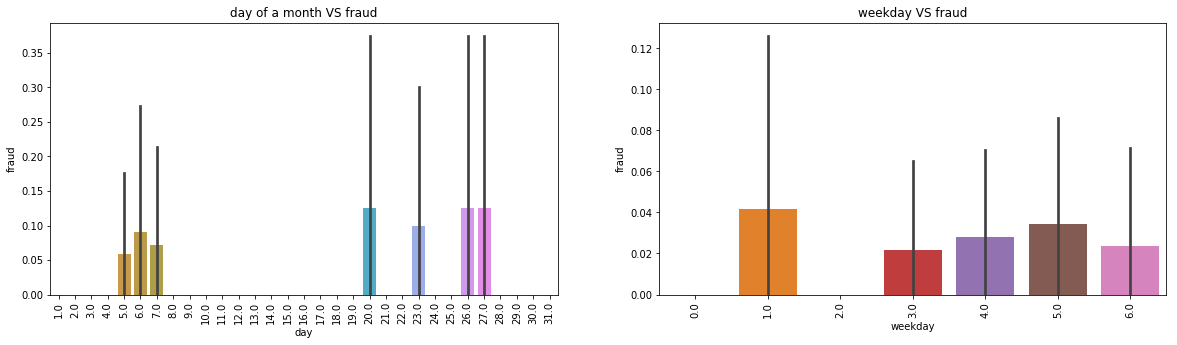

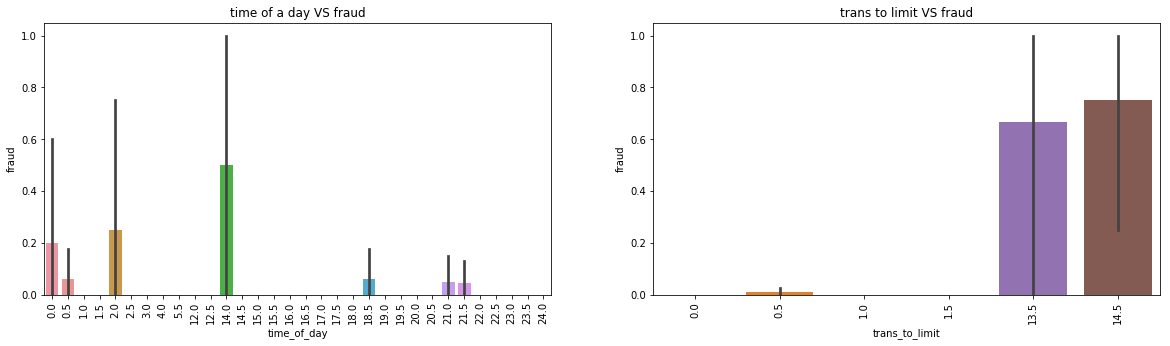

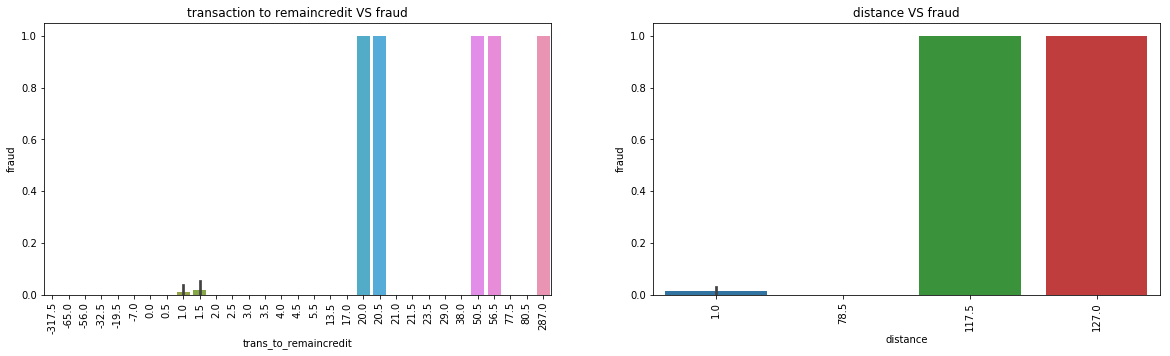

In [23]:
fraud_check(1280981422329509)

# Conclusion: 
For the user with card number 1280981422329509 (case will be different for different user):
- Transaction time information, including weekday, date of a month, or exact time of a day, would not necessary related to wheather it is a fraud transaction
- When the tranaction amount to credit limit is as large as 14, the tranaction need to be investigage
- A transaction with high amount to remaining credit ratio may also need investigation
- Long distance to its canter place will very likely to be identified as a fraud transaction